In [167]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from PIL import Image
from pathlib import Path
from typing import Sequence
from matplotlib.figure import Figure
from matplotlib.gridspec import GridSpec
from matplotlib.axes import Axes
from random import randint
from IPython.display import display

from ba_dev.dataset import MammaliaDataSequence, MammaliaDataImage
from ba_dev.transform import ImagePipeline, BatchImagePipeline
from ba_dev.eval_helpers import *
from ba_dev.utils import load_path_yaml

paths = load_path_yaml('../../data/path_config.yml')

set_custom_plot_style()
cm = 1 / 2.54

export = False

## Loading dataset as sequences and images

In [168]:
label_files = paths['labels'].glob('*.csv')

all_sequences = pd.DataFrame()

for label_file in label_files:
    new_sequences = pd.read_csv(label_file)
    all_sequences = pd.concat([all_sequences, new_sequences], ignore_index=True)

keys_to_keep = ['session', 'seq_id', 'Directory', 'n_files', 'all_files', 'label2']

all_sequences = all_sequences[keys_to_keep].rename(columns={'label2': 'class_label'})

allowed_values = ['apodemus_sp', 'cricetidae', 'mustela_erminea', 'soricidae']

filtered_sequences = all_sequences[all_sequences['class_label'].isin(allowed_values)].copy()

filtered_sequences['all_files'] = filtered_sequences['all_files'].str.split(',')

filtered_sequences[['conf_values', 'bboxes', 'max_conf']] = (
    filtered_sequences
    .apply(
        lambda row: get_md_info(
            seq_id=row['seq_id'],
            files_list=row['all_files'],
            md_output_dir=paths['md_output']
        ),
        axis=1,
        result_type='expand'
    ))

sequence_df = filtered_sequences.copy()

image_df = (
    filtered_sequences
    .explode(['all_files', 'conf_values', 'bboxes'])
    .rename(columns={
        'all_files': 'file',
        'conf_values': 'conf_value',
        'bboxes': 'bbox'
        })
    .assign(path=lambda df: df['Directory'] + '/' + df['file'])
    .drop(columns=['max_conf', 'Directory'])
    .reset_index(drop=True)
    )


## Analysing lost data on sequence and image level

In [172]:
# MD output - data available
########################################################################################################################
table_name = 'data_availability_after_md'
caption = r'Data loss dew to MD output for confidence thresholds of 0.25 and 0.5 by category.'
########################################################################################################################

df_seq = count_vs_threshold(sequence_df, thresholds=[0.25, 0.5], base_name="seq")
df_img = count_vs_threshold(image_df, thresholds=[0.25, 0.5], base_name="img")
joined_df = df_seq.merge(df_img, on='class_label')

keys = joined_df.keys()

lines = [
        '\\begin{table}',
        f'\\caption{{{caption}}}',
        f'\\label{{tab:{table_name}}}',
        '\\begin{tabular}{l r r r r}',
        '\\toprule'
        ]

last = 'first'
key_l = ''
treshold = '0'

for key in keys:

    info = key.split('_')

    if info[0] != last:
        
        if info[0] == 'seq':
            lines.append('\midrule')
            lines.append('\\textbf{Sequence Level} & & & & \\\\')
        elif info[0] == 'img':
            lines.append('\midrule')
            lines.append('\\textbf{Image Level} & & & & \\\\')
        
    last = info[0]
    
    if len(info) == 2:
        key_l = 'Total available'
    elif len(info) == 3:
        if info[2] != treshold:
            lines.append('\midrule')
            lines.append(f'Threshold of {info[2]}: & & & & \\\\')
            treshold = info[2]

        if info[1] == 'lost':
            key_l = 'Lost'
        elif info[1] == 'frac':
            key_l = 'Fraction lost'
        elif info[1] == 'avail':
            key_l = 'Available'


    data = joined_df[key].values

    data_str = ''

    for value in data:
        if isinstance(value, str):
            value = value.replace('_', '\_')
            key_l = ''
        else:
            value = str(value)
        
        data_str += ' & ' + value

    new_line = key_l + data_str + ' \\\\'
    lines.append(new_line)

lines.extend([
    '\\bottomrule',
    '\\end{tabular}',
    '\\end{table}'
    ])

latex = "\n".join(lines)
latex = place_table(latex, center=True, placement='H')

print(latex)

\begin{table}[H]
\centering
\caption{Data loss dew to MD output for confidence thresholds of 0.25 and 0.5 by category.}
\label{tab:data_availability_after_md}
\begin{tabular}{l r r r r}
\toprule
 & apodemus\_sp & cricetidae & mustela\_erminea & soricidae \\
\midrule
\textbf{Sequence Level} & & & & \\
Total available & 13669 & 5329 & 1035 & 2107 \\
\midrule
Threshold of 0.25: & & & & \\
Lost & 51 & 40 & 211 & 7 \\
Fraction lost & 0.0 & 0.01 & 0.2 & 0.0 \\
Available & 13618 & 5289 & 824 & 2100 \\
\midrule
Threshold of 0.5: & & & & \\
Lost & 56 & 46 & 239 & 13 \\
Fraction lost & 0.0 & 0.01 & 0.23 & 0.01 \\
Available & 13613 & 5283 & 796 & 2094 \\
\midrule
\textbf{Image Level} & & & & \\
Total available & 279492 & 156350 & 16465 & 16645 \\
\midrule
Threshold of 0.25: & & & & \\
Lost & 16609 & 9248 & 2914 & 3529 \\
Fraction lost & 0.06 & 0.06 & 0.18 & 0.21 \\
Available & 262883 & 147102 & 13551 & 13116 \\
\midrule
Threshold of 0.5: & & & & \\
Lost & 19417 & 11948 & 3290 & 3865 \\
Fraction l

In [ ]:
    \begin{table}
    \caption{Availability and loss fractions at sequence and image levels by species}
    \label{tab:sequence_image_loss}
    \begin{tabular}{l r r r r}
    \toprule
    & apodemus\_sp & cricetidae & mustela\_erminea & soricidae \\
    \midrule
    \textbf{Sequence Level} & & & & \\
    Total available & 13669 & 5329 & 1035 & 2107 \\
    \midrule
    Threshold of 0.25: & & & & \\
    Lost & 51 & 40 & 211 & 7 \\
    Fraction lost & 0.0 & 0.01 & 0.2 & 0.0 \\
    Available & 13618 & 5289 & 824 & 2100 \\
    \midrule
    Threshold of 0.5: & & & & \\
    Lost & 56 & 46 & 239 & 13 \\
    Fraction lost & 0.0 & 0.01 & 0.23 & 0.01 \\
    Available & 13613 & 5283 & 796 & 2094 \\
    \midrule
    \midrule
    \textbf{Image Level} & & & & \\
    Total available & 279492 & 156350 & 16465 & 16645 \\
    \midrule
    Threshold of 0.25: & & & & \\
    Lost & 16609 & 9248 & 2914 & 3529 \\
    Fraction lost & 0.06 & 0.06 & 0.18 & 0.21 \\
    Available & 262883 & 147102 & 13551 & 13116 \\
    \midrule
    Threshold of 0.5: & & & & \\
    Lost & 19417 & 11948 & 3290 & 3865 \\
    Fraction lost & 0.07 & 0.08 & 0.2 & 0.23 \\
    Available & 260075 & 144402 & 13175 & 12780 \\
    \bottomrule
    \end{tabular}
    \end{table}

[]

In [84]:
def file_count(
        df: pd.DataFrame,
        threshold: float
        ):
    
    keys = df.columns.tolist()
    if 'max_conf' in keys:
        apply_to = 'max_conf'
    elif 'conf_value' in keys:
        apply_to = 'conf_value'
    else:
        raise ValueError("DataFrame must contain 'max_conf' or 'conf_value' column.")
    
    return (
        df[df[apply_to] >= threshold]
        .groupby('class_label')
        .size()
        .drop(columns=['class_label'])
        ).tolist()

def difference(list1, list2):
    return[a - b for a, b in zip(list1, list2)]

def fraction(list1, list2):
    return[b / a for a, b in zip(list1, list2)]

In [87]:
keys = ['apodemus_sp', 'cricetidae', 'mustela_erminea', 'soricidae']

seq_all = file_count(sequence_df, 0)
seq_25 = file_count(sequence_df, 0.25)
seq_50 = file_count(sequence_df, 0.5)

imag_all = file_count(image_df, 0)
imag_25 = file_count(image_df, 0.25)
imag_50 = file_count(image_df, 0.5)

data = [
    seq_all,
    seq_25,
    difference(seq_all, seq_25),
    fraction(seq_all, seq_25),
    ]

df = pd.DataFrame(columns=keys, data=data)

df

apodemus_sp   cricetidae  mustela_erminea    soricidae
0  13669.000000  5329.000000      1035.000000  2107.000000
1  13618.000000  5289.000000       824.000000  2100.000000
2     51.000000    40.000000       211.000000     7.000000
3      0.996269     0.992494         0.796135     0.996678

In [69]:
images_all = file_count(image_df, 0)
images_25 = file_count(image_df, 0.25)
images_50 = file_count(image_df, 0.5)

In [82]:
images_all

[279492, 156350, 16465, 16645]

In [83]:
images_25

[262883, 147102, 13551, 13116]

In [81]:
difference(images_all, images_25)

[16609, 9248, 2914, 3529]

In [78]:
fraction(images_all, avail_25)

[0.05942567229115681,
 0.059149344419571474,
 0.17698147585788035,
 0.2120156203063983]

In [79]:
lost_50 = difference(images_all, images_50)

In [80]:
fraction(images_all, lost_50)

[0.06947247148397807,
 0.07641829229293252,
 0.1998177953234133,
 0.2322018624211475]

In [58]:
df

apodemus_sp  cricetidae  mustela_erminea  soricidae
0        13669        5329             1035       2107

In [34]:
file_count(sequence_df, 0.25)

class_label  count
0      apodemus_sp  13618
1       cricetidae   5289
2  mustela_erminea    824
3        soricidae   2100

In [23]:
df_seq = count_vs_threshold(sequence_df, thresholds=[0.25, 0.5], base_name="all_sequences")
df_img = count_vs_threshold(image_df, thresholds=[0.25, 0.5], base_name="all_images")

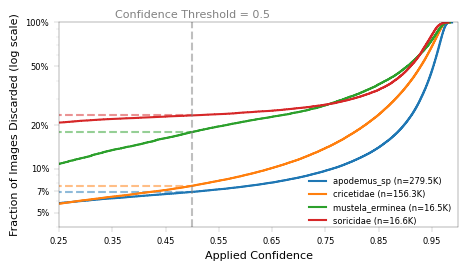

In [84]:
# Plot Fraction of Discarded Images by Applied Confidence
########################################################################################################################
fig_name = 'discarded_img_by_conf.pdf'
fig_size = (12*cm,7*cm)
conf_threshold = 0.5
########################################################################################################################

df = image_df

cdf_data = (
    df.sort_values(by='conf_value')
      .groupby('class_label', group_keys=False)
      .apply(lambda g: pd.DataFrame({
          'conf_value': np.sort(g['conf_value'].to_numpy()),
          'cum_density': np.linspace(0, 1, len(g)),
          'class_label': g.name  # this is the current group label
      }), include_groups=False)
      .reset_index(drop=True)
)

# Plotting
class_counts = df['class_label'].value_counts().to_dict()

plt.figure(figsize=fig_size)
for class_label, group in cdf_data.groupby('class_label'):
    count = class_counts.get(class_label, 0)
    label = f'{class_label} (n={count/1000:.1f}K)'
    
    line, = plt.plot(group['conf_value'], group['cum_density'], label=label)

    above_thresh = group[group['conf_value'] >= conf_threshold]
    if not above_thresh.empty:
        y_at_thresh = above_thresh['cum_density'].iloc[0]
        plt.hlines(y=y_at_thresh, xmin=0.24, xmax=conf_threshold, linestyle='--', alpha=0.5, color=line.get_color())

plt.axvline(x=conf_threshold, linestyle='--', color='gray', alpha=0.5)
plt.text(
    x=conf_threshold, y=1.08,
    s=f'Confidence Threshold = {conf_threshold}',
    horizontalalignment='center',
    fontsize=8,
    color='gray'
)

plt.xlabel('Applied Confidence')
plt.ylabel('Fraction of Images Discarded (log scale)')
plt.yscale('log')
plt.yticks(
    [0.05, 0.07, 0.1, 0.2, 0.5, 1], 
    labels=['5%', '7%', '10%', '20%', '50%', '100%']
    )
plt.xticks(
    np.arange(0.25, 1, 0.1),
    labels=[f'{x:.2f}' for x in np.arange(0.25, 1, 0.1)]
)
plt.legend(
    loc='lower right',
    bbox_to_anchor=(1, -0.03),
    frameon=False
)
plt.xlim(left=0.25, right=1)
plt.ylim(bottom=0.04, top=1)
plt.tight_layout()

    
plt.show()

In [24]:
sequence_df

session   seq_id                             Directory  n_files  \
1            1  1000001               sessions/session_01/H_2        6   
2            1  1000002               sessions/session_01/H_2        6   
3            1  1000003               sessions/session_01/H_2        3   
4            1  1000004               sessions/session_01/H_2        3   
5            1  1000005               sessions/session_01/H_2        3   
...        ...      ...                                   ...      ...   
23228        2  2000486  sessions/session_02/H550HF08161376_2       45   
23229        2  2000487  sessions/session_02/H550HF08161376_2       45   
23230        2  2000488  sessions/session_02/H550HF08161376_2       78   
23231        2  2000489  sessions/session_02/H550HF08161376_2       30   
23232        2  2000490  sessions/session_02/H550HF08161376_2        9   

                                               all_files      class_label  \
1      [RCNX0005.JPG, RCNX0006.JPG, RCNX0007.JPG, RCN...      apodemus_sp   
2      [RCNX0013.JPG, RCNX0014.JPG, RCNX0015.JPG, RCN...  mustela_erminea   
3             [RCNX0021.JPG, RCNX0022.JPG, RCNX0023.JPG]  mustela_erminea   
4             [RCNX0025.JPG, RCNX0026.JPG, RCNX0027.JPG]  mustela_erminea   
5             [RCNX0029.JPG, RCNX0030.JPG, RCNX0031.JPG]  mustela_erminea   
...                                                  ...              ...   
23228  [IMG_4312_2.JPG, IMG_4313_2.JPG, IMG_4314_2.JP...       cricetidae   
23229  [IMG_4357_2.JPG, IMG_4358_2.JPG, IMG_4359_2.JP...       cricetidae   
23230  [IMG_4402_2.JPG, IMG_4403_2.JPG, IMG_4404_2.JP...       cricetidae   
23231  [IMG_4480_2.JPG, IMG_4481_2.JPG, IMG_4482_2.JP...       cricetidae   
23232  [IMG_4510_2.JPG, IMG_4511_2.JPG, IMG_4512_2.JP...       cricetidae   

                                             conf_values  max_conf  
1             [0.961, 0.957, 0.968, 0.837, 0.975, 0.949]     0.975  
2              [0.735, 0.551, 0.86, 0.284, 0.269, 0.322]     0.860  
3                                  [0.911, 0.934, 0.936]     0.936  
4                                      [0.86, 0.96, 0.0]     0.960  
5                                  [0.962, 0.938, 0.398]     0.962  
...                                                  ...       ...  
23228  [0.862, 0.704, 0.789, 0.714, 0.928, 0.929, 0.9...     0.952  
23229  [0.936, 0.926, 0.967, 0.959, 0.936, 0.96, 0.78...     0.967  
23230  [0.937, 0.917, 0.881, 0.856, 0.84, 0.954, 0.92...     0.957  
23231  [0.832, 0.759, 0.0, 0.705, 0.785, 0.828, 0.87,...     0.941  
23232  [0.669, 0.0, 0.0, 0.945, 0.938, 0.947, 0.0, 0....     0.947  

[22140 rows x 8 columns]

## visual inspection

In [25]:
scaling_factor = 0.5

image_pipeline = ImagePipeline(
                pre_ops=[
                    ('reduce_resolution', {'factor': scaling_factor})
                ]
                )

dataset_img = MammaliaDataImage(
    path_labelfiles=paths['labels'],
    path_to_dataset=paths['dataset'],
    path_to_detector_output=paths['md_output'],
    detector_model=None,
    mode='eval',
    image_pipeline=image_pipeline,
)

image_pipeline = BatchImagePipeline(
                pre_ops=[
                    ('reduce_resolution', {'factor': scaling_factor})
                ]
                )

dataset_seq = MammaliaDataSequence(
    path_labelfiles=paths['labels'],
    path_to_dataset=paths['dataset'],
    path_to_detector_output=paths['md_output'],
    detector_model=None,
    mode='eval',
    image_pipeline=image_pipeline,
)


/Users/jk/MyPythonPackages/BA_package/ba_dev/dataset.py:249: UserWarning: With the detection confidence of 0.25,
309 sequences had no detections and will be excluded.
Excluded sequences: [6000646, 6000663, 6000665, 6000679, 6000680, 6000681, 6000683, 4001841, 1001523, 6000691] ...
  warnings.warn(
/Users/jk/MyPythonPackages/BA_package/ba_dev/dataset.py:249: UserWarning: With the detection confidence of 0.25,
309 sequences had no detections and will be excluded.
Excluded sequences: [6000646, 6000663, 6000665, 6000679, 6000680, 6000681, 6000683, 4001841, 1001523, 6000691] ...
  warnings.warn(


In [26]:
df = dataset_img.ds.copy()

summary_df = (
    df.groupby('seq_id', group_keys=False)
      .agg(
          n_images=('conf', 'count'),
          min_conf=('conf', 'min'),
          max_conf=('conf', 'max')
      )
      .reset_index()
)
summary_df['conf_range'] = summary_df['max_conf'] - summary_df['min_conf']

summary_df_sorted = summary_df.sort_values(by='conf_range', ascending=False)


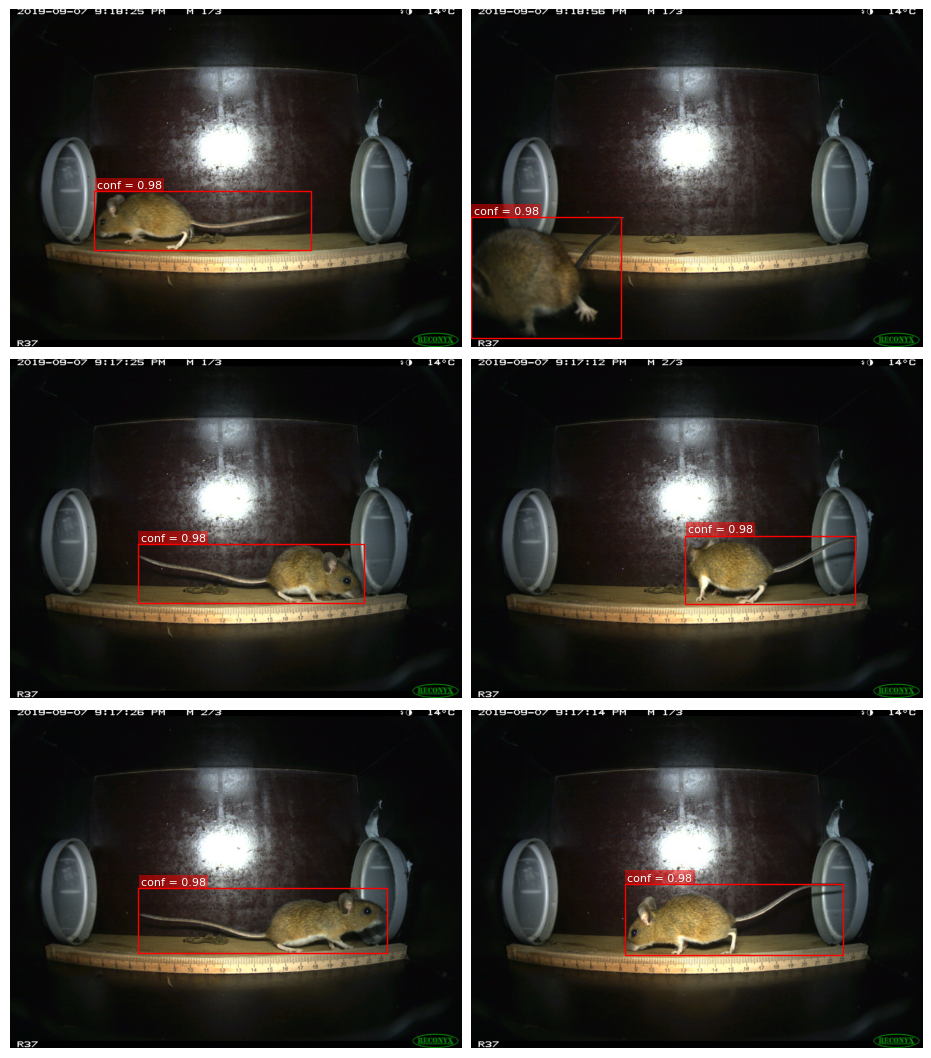

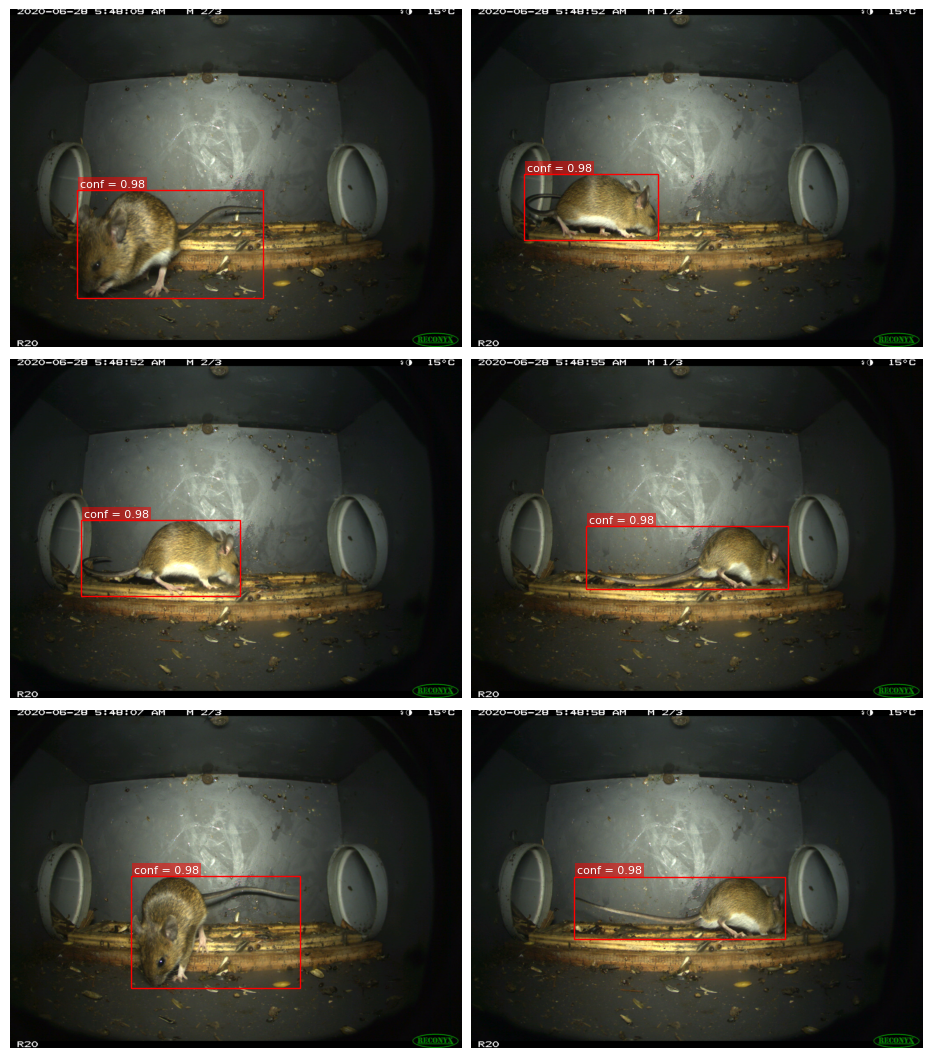

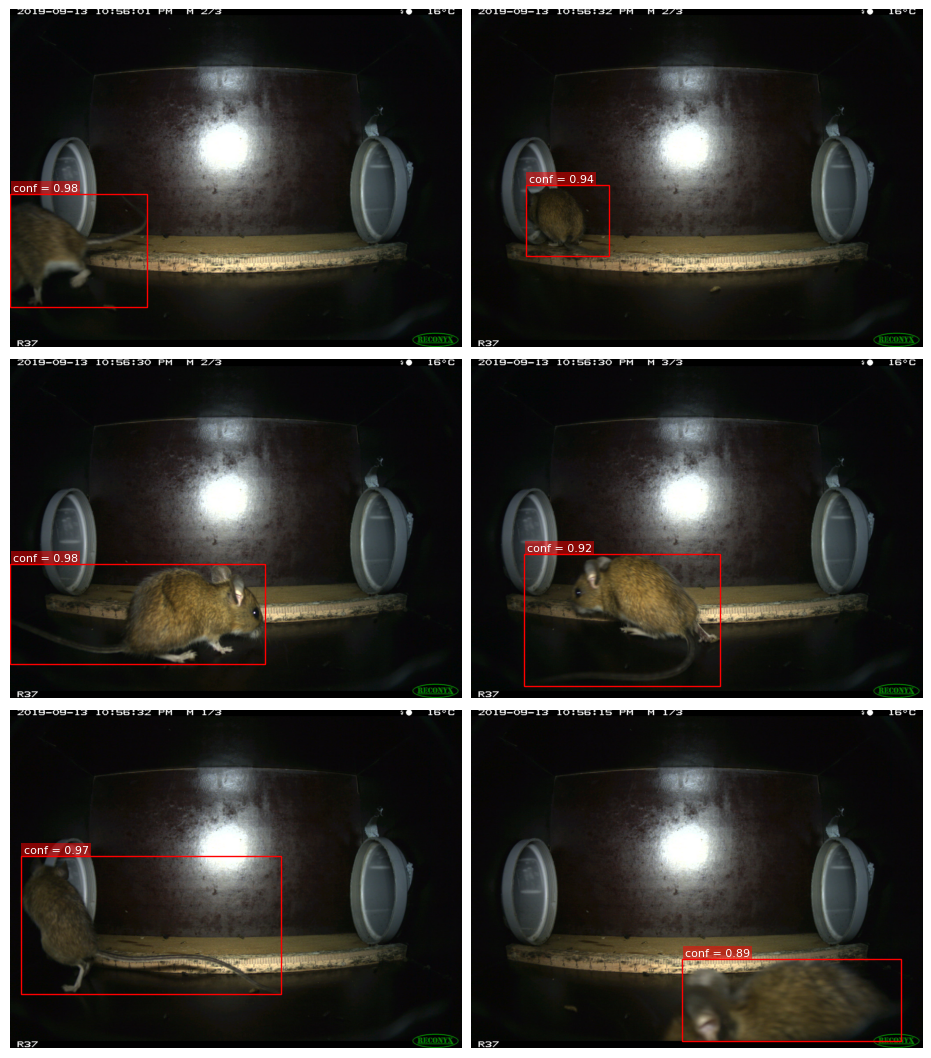

In [27]:
n_plots = 3
fig_width = 24*cm
target_path = Path('/cfs/earth/scratch/kraftjul/BA/output/conf_examples')

for seq_id in summary_df_sorted['seq_id'].tolist()[:n_plots]:

    i = dataset_seq.get_index_by_seq_id(seq_id)
    sequence = dataset_seq[i]

    length = len(sequence['sample'])

    if length >= 6:
        nrows = 3
        ncols = 2
    else:
        raise ValueError("The sequence is too short to be displayed in a 3x2 grid.")

    fig = plt.figure(figsize=(fig_width, fig_width * nrows / ncols * 3/4))
    gs = GridSpec(
        nrows=nrows, ncols=ncols,
        figure=fig,
        )

    for col in range(ncols):
        for row in range(nrows):
            ax = fig.add_subplot(gs[row, col])

            if col == 0:
                idx = row
            else:
                idx = -(nrows - row)

            img = sequence['sample'][idx]
            bbox = sequence['bbox'][idx]
            conf = sequence['conf'][idx]

            draw_bbox_on_ax(ax, img, bbox, conf)

    fig.tight_layout()



In [28]:
seq_id_to_load = 4000575
i = dataset_seq.get_index_by_seq_id(seq_id_to_load)
sequence = dataset_seq[i]

In [29]:
len(sequence['sample'])

10

In [30]:
sequence['sample']

[<PIL.Image.Image image mode=RGB size=1024x768>,
 <PIL.Image.Image image mode=RGB size=1024x768>,
 <PIL.Image.Image image mode=RGB size=1024x768>,
 <PIL.Image.Image image mode=RGB size=1024x768>,
 <PIL.Image.Image image mode=RGB size=1024x768>,
 <PIL.Image.Image image mode=RGB size=1024x768>,
 <PIL.Image.Image image mode=RGB size=1024x768>,
 <PIL.Image.Image image mode=RGB size=1024x768>,
 <PIL.Image.Image image mode=RGB size=1024x768>,
 <PIL.Image.Image image mode=RGB size=1024x768>]

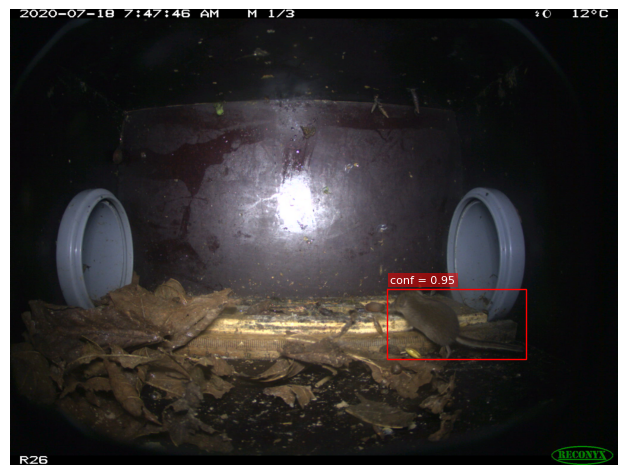

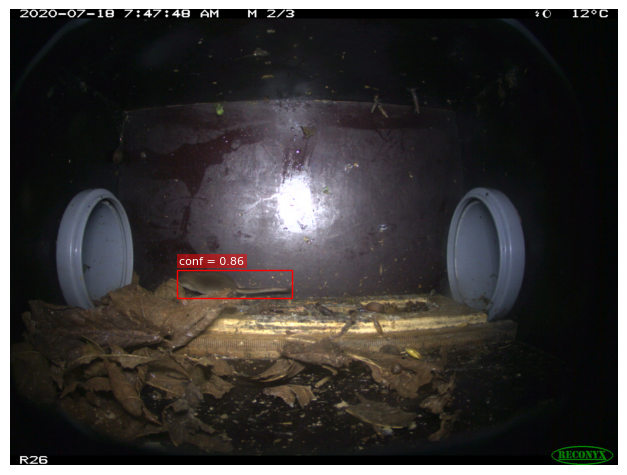

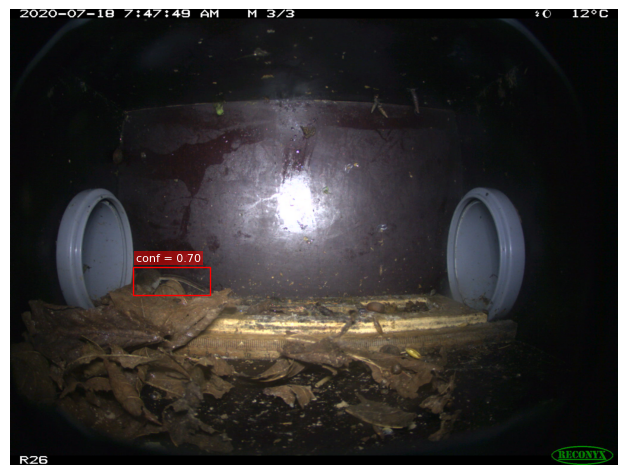

In [31]:
interessting_sequences = [4011876, 4018688]

i = dataset_seq.get_index_by_seq_id(interessting_sequences[1])
sequence = dataset_seq[i]

for image, bbox, conf in zip(sequence['sample'], sequence['bbox'], sequence['conf']):
    fig = plot_image_with_bbox(image=image, bbox=bbox, conf=conf)
    display(fig)

Randomly selected index: 422642
class_label: cricetidae
seq_id: 2000210


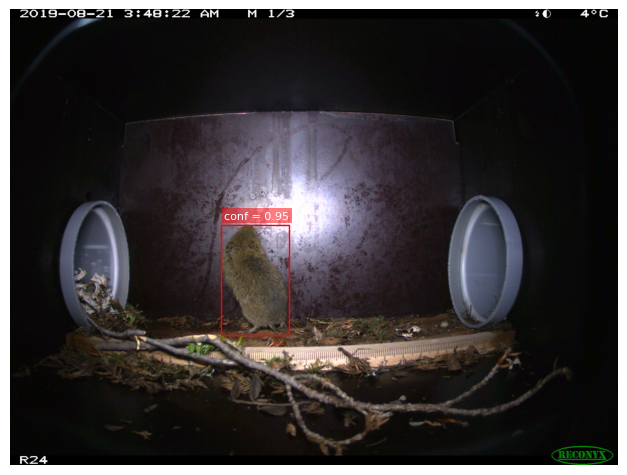

In [32]:
i = randint(0, len(dataset_img) - 1)
print(f"Randomly selected index: {i}")
sample = dataset_img[i]
print(f'class_label: {sample["class_label"]}')
print(f'seq_id: {sample["seq_id"]}')

fig = plot_image_with_bbox(image=sample['sample'], bbox=sample['bbox'], conf=sample['conf'])
display(fig)

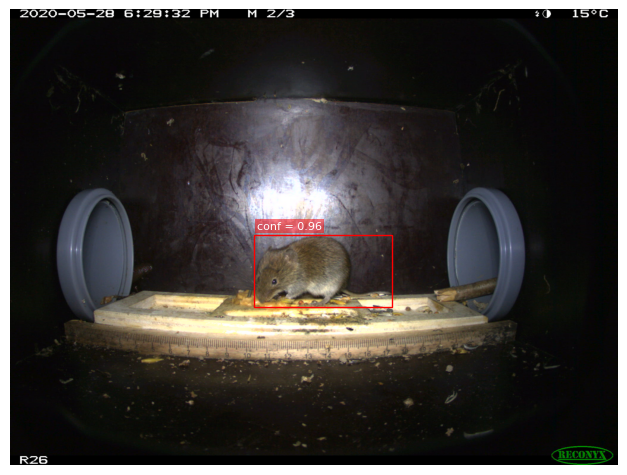

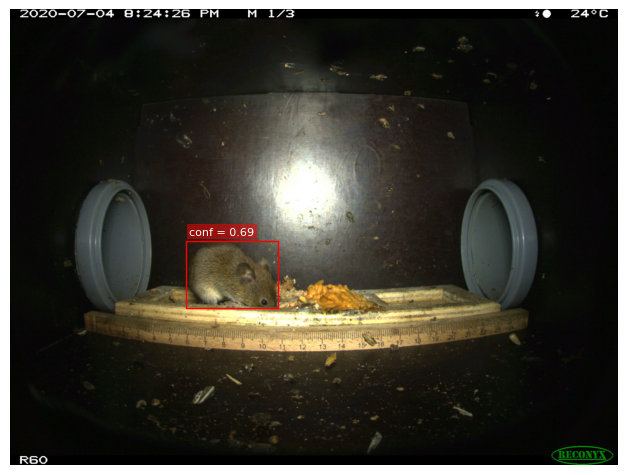

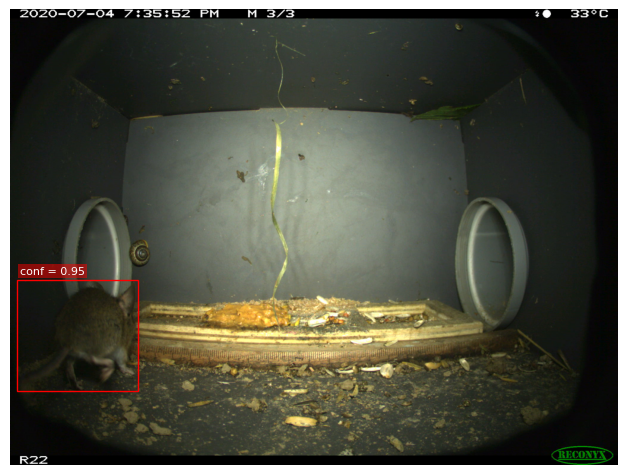

In [33]:
interesting_images = [108812, 340523, 319527]

for i in interesting_images:
    sample = dataset_img[i]
    figure = plot_image_with_bbox(image=sample['sample'], bbox=sample['bbox'], conf=sample['conf'])
    display(figure)

In [34]:
lowest_conf_indices = dataset_img.ds.nsmallest(5, 'conf').index.tolist()

for i in lowest_conf_indices:
    sample = dataset_img[i]
    figure = plot_image_with_bbox(image=sample['x'], bbox=sample['bbox'], conf=sample['conf'])
    display(figure)
    

KeyError: 'x'

In [ ]:
# Plot Fraction of Discarded Images by Applied Confidence
########################################################################################################################
fig_name = 'discarded_img_by_conf.pdf'
fig_size = (12*cm,7*cm)
conf_threshold = 0.5
scaling_factor = 0.5
########################################################################################################################

image_pipeline = ImagePipeline(
                pre_ops=[
                    ('reduce_resolution', {'factor': scaling_factor})
                ]
                )

dataset_img = MammaliaDataImage(
    path_labelfiles=paths['labels'],
    path_to_dataset=paths['dataset'],
    path_to_detector_output=paths['md_output'],
    detector_model=None,
    mode='eval',
    image_pipeline=image_pipeline,
)

df = dataset_img.ds

cdf_data = (
    df.sort_values(by='conf')
      .groupby('class_label', group_keys=False)
      .apply(lambda g: pd.DataFrame({
          'conf': np.sort(g['conf'].to_numpy()),
          'cum_density': np.linspace(0, 1, len(g)),
          'class_label': g.name  # this is the current group label
      }), include_groups=False)
      .reset_index(drop=True)
)

# Plotting
class_counts = df['class_label'].value_counts().to_dict()

plt.figure(figsize=fig_size)
for class_label, group in cdf_data.groupby('class_label'):
    count = class_counts.get(class_label, 0)
    label = f'{class_label} (n={count/1000:.1f}K)'
    
    line, = plt.plot(group['conf'], group['cum_density'], label=label)

    above_thresh = group[group['conf'] >= conf_threshold]
    if not above_thresh.empty:
        y_at_thresh = above_thresh['cum_density'].iloc[0]
        plt.hlines(y=y_at_thresh, xmin=0.24, xmax=conf_threshold, linestyle='--', alpha=0.5, color=line.get_color())

plt.axvline(x=conf_threshold, linestyle='--', color='gray', alpha=0.5)
plt.text(
    x=conf_threshold, y=1.08,
    s=f'Confidence Threshold = {conf_threshold}',
    horizontalalignment='center',
    fontsize=8,
    color='gray'
)

plt.xlabel('Applied Confidence')
plt.ylabel('Fraction of Images Discarded (log scale)')
plt.yscale('log')
plt.yticks(
    [0.01, 0.02, 0.03, 0.05, 0.07, 0.1, 0.2, 0.5, 1], 
    labels=['1%', '2%', '3%', '5%', '7%', '10%', '20%', '50%', '100%']
    )
plt.legend(
    loc='lower right',
    bbox_to_anchor=(1, -0.03),
    frameon=False
)
plt.xlim(left=0.24, right=1)
plt.ylim(bottom=0.01, top=1)
plt.tight_layout()
    
plt.show()

In [ ]:
# Plot Fraction of Discarded Sequences by Applied Confidence
########################################################################################################################
fig_name = 'discarded_seq_by_conf.pdf'
fig_size = (12*cm,7*cm)
conf_threshold = 0.5
########################################################################################################################

seq_class_conf = (
    df.groupby(['class_label', 'seq_id'])['conf']
      .max()
      .reset_index(name='max_conf')
    )
cdf_parts = []

for class_label, group in seq_class_conf.groupby('class_label'):
    conf_sorted = np.sort(group['max_conf'].to_numpy())
    cum_density = np.linspace(0, 1, len(conf_sorted))

    part_df = pd.DataFrame({
        'class_label': class_label,
        'max_conf': conf_sorted,
        'cum_density': cum_density
    })

    cdf_parts.append(part_df)

cdf_seq = pd.concat(cdf_parts, ignore_index=True)

seq_counts = seq_class_conf['class_label'].value_counts().to_dict()

plt.figure(figsize=fig_size)
for class_label, group in cdf_seq.groupby('class_label'):
    count = seq_counts.get(class_label, 0)
    label = f"{class_label} (n={count/1000:.1f}K)"
    
    line, = plt.plot(group['max_conf'], group['cum_density'], label=label)

    # Horizontal marker at the confidence threshold
    above_thresh = group[group['max_conf'] >= conf_threshold]
    if not above_thresh.empty:
        y_at_thresh = above_thresh['cum_density'].iloc[0]
        plt.hlines(y=y_at_thresh, xmin=0.24, xmax=conf_threshold, linestyle='--', alpha=0.5, color=line.get_color())

# Global reference lines
plt.axvline(x=conf_threshold, linestyle='--', color='gray', alpha=0.5)
plt.text(
    x=conf_threshold, y=1.08,
    s=f'Confidence = {conf_threshold}',
    horizontalalignment='center',
    fontsize=8,
    color='gray'
)

# Axes styling
plt.xlabel("Applied Confidence")
plt.ylabel("Fraction of Sequences Discarded (log scale)")
plt.yscale('log')
plt.yticks(
    [0.01, 0.02, 0.03, 0.05, 0.07, 0.1, 0.2, 0.5, 1],
    labels=['1%', '2%', '3%', '5%', '7%', '10%', '20%', '50%', '100%']
    )
plt.legend(frameon=False)
plt.xlim(left=0.24, right=1)
plt.ylim(bottom=0.002, top=1)
plt.tight_layout()

plt.show()